# Generate pendulum trajectories of motion

This notebook generates a dataset of pendulum swings, covering the entirety of the state space.

## Control Options

In [1]:
## Type of pendulum
pendulum_type = 'rigid'

## Control signal
control = None
#control = 'pd'

## Viscous friction
friction = 0

In [2]:
%matplotlib notebook

# Define a model of a pendulum and its dynamics

In [3]:
import numpy as np
import sys
sys.path.append('libraries/dynamics/pendulum') # Simulation from Tutorial A in libraries form
from model_pendulum import model_pendulum
from fn_dynamics_pendulum import fn_dynamics_pendulum
from simulate_step import simulate_step

m  = model_pendulum(G=-1,mu=friction)   # Define the parameters of the pendulum 

if pendulum_type =='rigid':
    fn = fn_dynamics_pendulum  # Define the dynamics of the motion
elif pendulum_type =='double':
    fn = fn_dynamics_double_pendulum  # Define the dynamics of the motion    
elif pendulum_type =='soft':
    fn = fn_dynamics_soft_pendulum  # Define the dynamics of the motion   

if control=='pd':
    # PD control
    def fun_u(x):
        xt = [np.pi,0] #target
        Kp = 10
        Kd = 3
        return -(Kp*(x[0]-xt[0]) + Kd*(x[1]-xt[1]))
else:
    # #Zero control
    def fun_u(x):
        return np.zeros(1)   
    
p  = 'rk4' # solver
dt = 0.02
N  = 51 

# Define ranges 
x1range = [-3.1,3.1] # angle
x2range = [-2, 2]    # angular velocity

# Function to generate the state sequences

In [4]:
# Potential function to check if the pendulum swings over the top
potential = lambda x,y : (1/2)*y**2-np.cos(x)

def simulate_trajectory(x0,N):
    # Simulate the dynamics
    t = np.zeros(N) # timesteps
    u = np.zeros(N) # control
    x = np.zeros((2,N)) # state
    x[:,0] = x0

    # For each timestep  
    for n in range(N-1):
        u[n] = fun_u(x[:,n])
        x[:,n+1] = simulate_step(fn,x[:,n],u[n],m,dt,p)
        t[n+1] = t[n] + dt
    return x,u
    

def generate_random_trajectories(n_samples):
    X = list()
    for i in range(n_samples):
        # This valid swing is used to make sure we don't record data over the pendulum swinging over the top
        # This is because the ULE paper looks at trajectories that go to infinite period (slows but never reaches top)
        valid_swing = False
        while not valid_swing:
            x0 = (np.random.uniform(low=x1range[0], high=x1range[1], size=(1,)),
                  np.random.uniform(low=x2range[0], high=x2range[1], size=(1,))) # Starting position, in form [theta,omega]
  
            if potential(x0[0],x0[1])< 1:
                valid_swing = True
                x,u = simulate_trajectory(x0,N)
                X.append(np.vstack([x,u]).T)
    return np.array(X)

# Visualise some examples

<IPython.core.display.Javascript object>


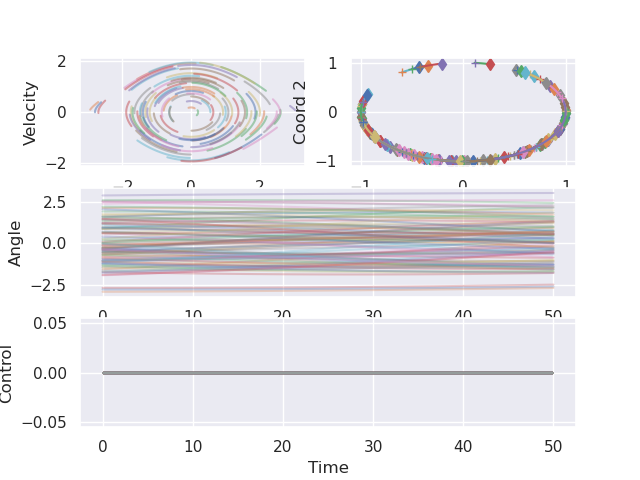

/tmp/ipykernel_96727/3770107138.py:9: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  x[:,0] = x0


In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)

N_trahj = 100
fig = plt.figure()
X_test = generate_random_trajectories(N_trahj)

for i in range(N_trahj):
    plt.subplot(321)
    plt.plot((X_test[i,:,0]),(X_test[i,:,1]),alpha=0.5)
    plt.xlabel('Angle'),plt.ylabel('Velocity')

    plt.subplot(322)
    r = np.empty((X_test.shape[1],2)) 
    r[:,0] = m['L1']*np.sin(X_test[i,:,0])
    r[:,1] = m['L1']*-np.cos(X_test[i,:,0])
    plt.plot(r[:,0],r[:,1])
    plt.plot(r[0,0],r[0,1],marker='d',label='start')
    plt.plot(r[-1,0],r[-1,1],marker='+',label='end')
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    plt.xlabel('Coord 1'),plt.ylabel('Coord 2')
    
    plt.subplot(312)
    plt.plot(X_test[i,:,0],'-',alpha=0.3)
    plt.xlabel('Time')
    plt.ylabel('Angle')
    
    plt.subplot(313)
    plt.plot(X_test[i,:,2],'-',alpha=0.3)
    plt.xlabel('Time')
    plt.ylabel('Control')

# Save to file incrementally

In [6]:
import h5py

num_train = 15000
num_test = 3000
num_valid = 1000
batch_size = 100 # How many batches per iteration (should be low for speed)

def save_state_to_file(name,num_samples):
    f = h5py.File("./data/{}.hdf5".format(name), 'a')
    for i in range(num_samples//batch_size):
        X_states = generate_random_trajectories(batch_size)     
        if i == 0:# Create the dataset at first
            f.create_dataset("state_t", data=X_states[:,:N-1], chunks=True, maxshape=(None,N-1,X_states.shape[2]))
            f.create_dataset("state_tp1", data=X_states[:,1:], chunks=True, maxshape=(None,N-1,X_states.shape[2]))
        else:# Append new data to it
            f['state_t'].resize((f['state_t'].shape[0] + X_states.shape[0]), axis=0)
            f['state_t'][-X_states.shape[0]:] = X_states[:,:N-1]
            f['state_tp1'].resize((f['state_tp1'].shape[0] + X_states.shape[0]), axis=0)
            f['state_tp1'][-X_states.shape[0]:] = X_states[:,1:]          
    f.close()

save_state_to_file('train',num_train)   
save_state_to_file('test',num_test) 
save_state_to_file('valid',num_valid) 

# Generate longer trajectories for evaluating long term predictions

In [7]:
# Method to generate a sequential list of delay coordinates, from an initial starting point
# This is so we can evaluate the evolution through the latent space
def generate_delay_list(x0,N):
    X = list()
    x,u = simulate_trajectory(x0,N)
    X.append(np.vstack([x,u]).T) # Add the control signal as the final column (even if u=0, we can just ignore later)
    return np.array(X)

# Visualise

<IPython.core.display.Javascript object>


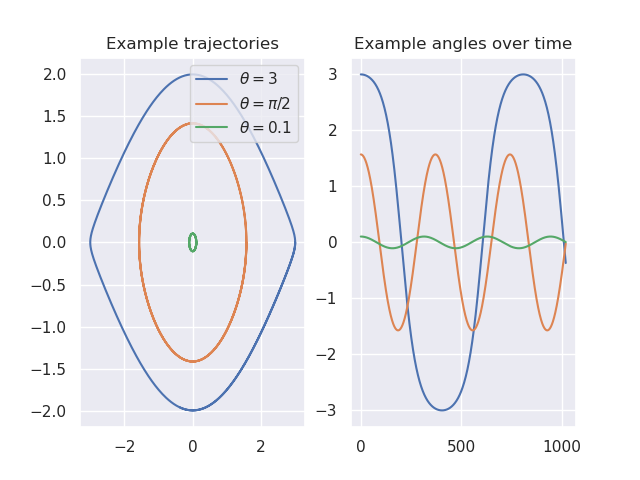

In [10]:
N_long = int(N*20)

# # For the full range pendulum
X_states_top = generate_delay_list([3,0],N_long)# Start near the top of the swing
X_states_mid = generate_delay_list([np.pi/2,0],N_long) # Start at a 90deg angle
X_states_bottom = generate_delay_list([np.deg2rad(6),0],N_long) # Start at the bottom

fig = plt.figure()
plt.subplot(121)
plt.plot(X_states_top[0,:,0],X_states_top[0,:,1],label=r'$\theta=3$')
plt.plot(X_states_mid[0,:,0],X_states_mid[0,:,1],label=r'$\theta=\pi/2$')
plt.plot(X_states_bottom[0,:,0],X_states_bottom[0,:,1],label=r'$\theta=0.1$')
plt.title('Example trajectories')
plt.legend()
plt.subplot(122)
plt.plot(X_states_top[0,:,0])
plt.plot(X_states_mid[0,:,0])
plt.plot(X_states_bottom[0,:,0])
plt.title('Example angles over time')


X_states_top = np.array([X_states_top[0,i:i+N,:] for i in range(N_long-N)])
X_states_mid = np.array([X_states_mid[0,i:i+N,:] for i in range(N_long-N)])
X_states_bottom = np.array([X_states_bottom[0,i:i+N,:] for i in range(N_long-N)])

# Save to file incrementally

In [9]:
def save_long_traj(X_states,name):
    f = h5py.File("./data/{}.hdf5".format(name), 'a')
    f.create_dataset("state_t", data=X_states[:,:N-1], chunks=True, maxshape=(None,N-1,X_states.shape[2]))
    f.create_dataset("state_tp1", data=X_states[:,1:], chunks=True, maxshape=(None,N-1,X_states.shape[2]))
    f.close()

save_long_traj(X_states_top,'top')   
save_long_traj(X_states_mid,'mid') 
save_long_traj(X_states_bottom,'bottom') 